# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00


Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import random

import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [7]:
words = Counter()
proccessed_text_test_list = [] # взглянем на предложения после процессинга, но до токенизации

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))
    proccessed_text_test_list.append(prccessed_text)

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


### Рандомное предложение до и после предобработки:

In [8]:
index = random.randint(0, 1000)
print(f'index = {index}')
print(len(dataset['train'][index]['text']))
print(dataset['train'][index]['text'])
print(len(proccessed_text_test_list[index]))
print(proccessed_text_test_list[index])

index = 431
252
News: UK scientists roll out Wi-Fi proof wallpaper British boffins have developed wallpaper that blocks Wi-Fi traffic but still allows other wireless transmissions to pass through in a bid to prevent unauthorised access to sensitive data via the WLAN.\
247
news uk scientists roll out wifi proof wallpaper british boffins have developed wallpaper that blocks wifi traffic but still allows other wireless transmissions to pass through in a bid to prevent unauthorised access to sensitive data via the wlan


In [9]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [10]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

### Рандомное предложение до и после токенизации:

In [11]:
print(len(dataset['train'][index]['text']))
print(dataset['train'][index]['text'])
print(len(train_dataset[index]['text']))
print(list(map(ind2word.get, train_dataset[index]['text'])))

252
News: UK scientists roll out Wi-Fi proof wallpaper British boffins have developed wallpaper that blocks Wi-Fi traffic but still allows other wireless transmissions to pass through in a bid to prevent unauthorised access to sensitive data via the WLAN.\
41
['<bos>', 'news', 'uk', 'scientists', 'roll', 'out', 'wifi', 'proof', '<unk>', 'british', '<unk>', 'have', 'developed', '<unk>', 'that', 'blocks', 'wifi', 'traffic', 'but', 'still', 'allows', 'other', 'wireless', '<unk>', 'to', 'pass', 'through', 'in', 'a', 'bid', 'to', 'prevent', '<unk>', 'access', 'to', 'sensitive', 'data', 'via', 'the', '<unk>', '<eos>']


## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [12]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# ------------------------------------------------- Baseline CharLM model --------------------------------------------

In [12]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [13]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [14]:
print(model)

CharLM(
  (embedding): Embedding(11842, 256)
  (rnn): RNN(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [15]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

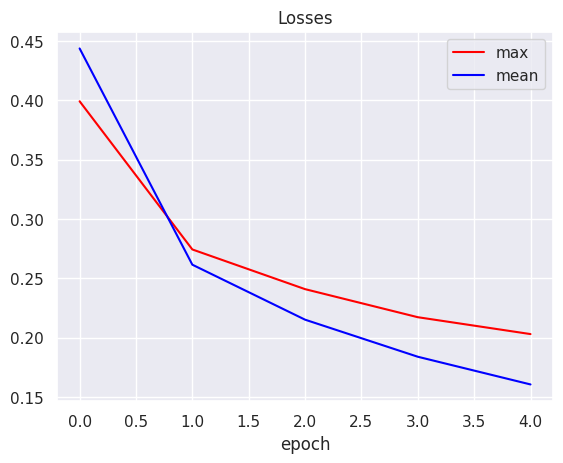

In [18]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.54
Лучшая accuracy для подхода mean: 90.86


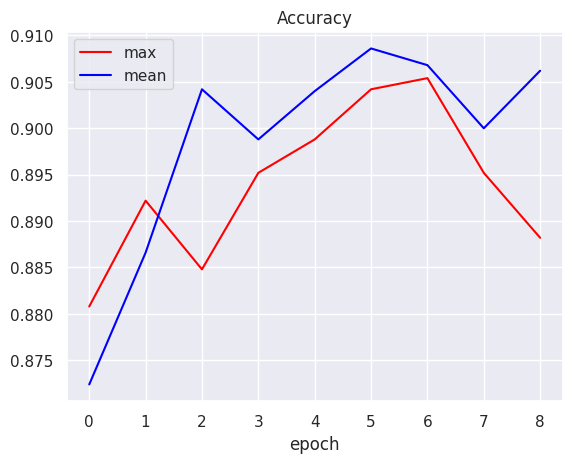

In [19]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# -------------------------------------------------------- Experiments --------------------------------------------------------

## ------------------------------------------------------------------- GRU -------------------------------------------------------------------

In [ ]:
class CharLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model_GRU = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_GRU.parameters())

In [ ]:
print(model_GRU)

CharLM_GRU(
  (embedding): Embedding(11842, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU = {}
acc_type_GRU = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU = CharLM_GRU(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU.eval()
                acc.append(evaluate(modmodel_GRUel, eval_dataloader))
                model_GRU.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU[aggregation_type] = losses
    acc_type_GRU[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

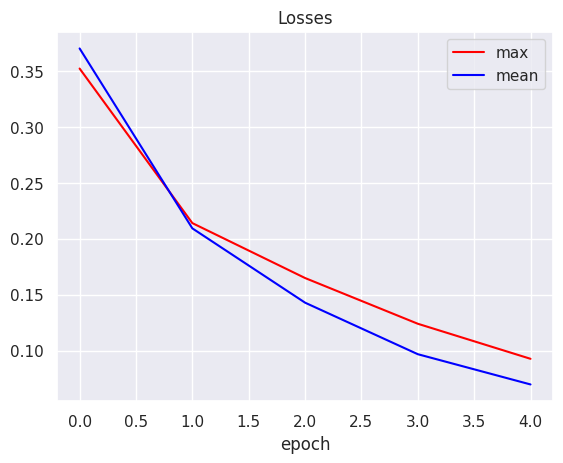

In [ ]:
for (name, values), color in zip(losses_type_GRU.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU[name])), losses_type_GRU[name], color=color, label=name)

plt.title('Losses GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.84
Лучшая accuracy для подхода mean: 91.64


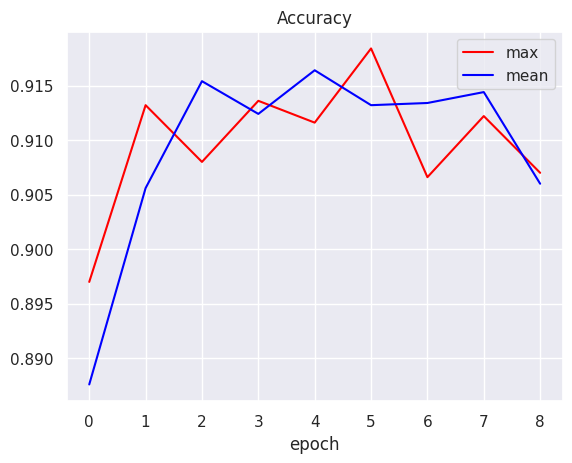

In [ ]:
for (name, values), color in zip(losses_type_GRU.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU[name][1:])), acc_type_GRU[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU[name]) * 100):.2f}")

plt.title('Accuracy GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

## ------------------------------------------------------------------- LSTM -------------------------------------------------------------------

In [ ]:
class CharLM_LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model_LSTM = CharLM_LSTM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_LSTM.parameters())

In [ ]:
print(model_LSTM)

CharLM_LSTM(
  (embedding): Embedding(11842, 256)
  (rnn): LSTM(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM = {}
acc_type_LSTM = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM = CharLM_LSTM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM.eval()
                acc.append(evaluate(model_LSTM, eval_dataloader))
                model_LSTM.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM[aggregation_type] = losses
    acc_type_LSTM[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

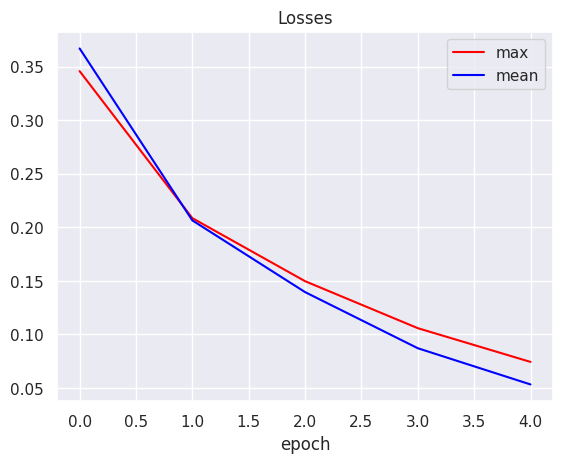

In [ ]:
for (name, values), color in zip(losses_type_LSTM.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM[name])), losses_type_LSTM[name], color=color, label=name)

plt.title('Losses LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.64
Лучшая accuracy для подхода mean: 91.48


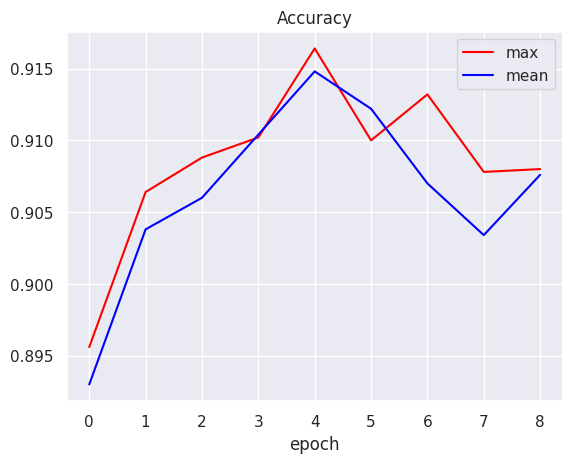

In [ ]:
for (name, values), color in zip(losses_type_LSTM.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM[name][1:])), acc_type_LSTM[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM[name]) * 100):.2f}")

plt.title('Accuracy LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

## --------------------------------------------------- GRU mean agg N layers -------------------------------------------------

In [20]:
class CharLM_GRU_N_layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [23]:
model_GRU_Nl = CharLM_GRU_N_layers(hidden_dim=256, vocab_size=len(vocab), aggregation_type='max', N_layers=5).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_GRU_Nl.parameters())

In [24]:
print(model_GRU_Nl)

CharLM_GRU_N_layers(
  (embedding): Embedding(11842, 256)
  (rnn): GRU(256, 256, num_layers=5, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [25]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_Nl = {}
acc_type_GRU_Nl = {}

# for aggregation_type in ['max', 'mean']:
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_Nl = CharLM_GRU_N_layers(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type, N_layers=5).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_Nl.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_Nl.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_Nl(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_Nl.eval()
                acc.append(evaluate(model_GRU_Nl, eval_dataloader))
                model_GRU_Nl.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_Nl[aggregation_type] = losses
    acc_type_GRU_Nl[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

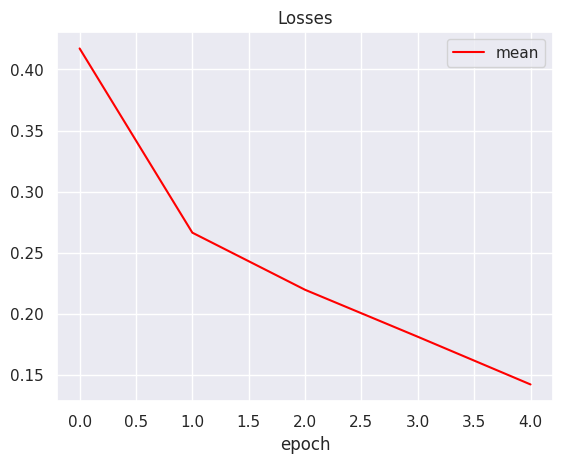

In [27]:
for (name, values), color in zip(losses_type_GRU_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_Nl[name])), losses_type_GRU_Nl[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.00


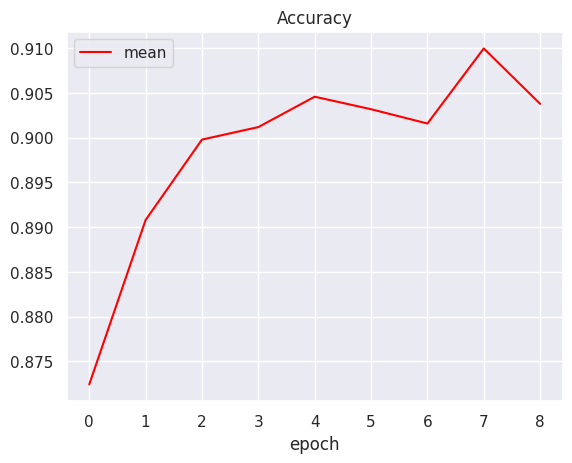

In [28]:
for (name, values), color in zip(losses_type_GRU_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_Nl[name][1:])), acc_type_GRU_Nl[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_Nl[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# ------------------------------------------ GRU (mean) + concatenation -------------------------------------------

In [29]:
class CharLM_GRU_cat(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim*3, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output_agg = output.max(dim=1)[0] #[batch_size, hidden_dim]
            output_last = output[:,-1,:] #[batch_size, hidden_dim]
            output_first = output[:,0,:] #[batch_size, hidden_dim]
            output = torch.cat([output_agg, output_last], dim=1) #[batch_size, hidden_dim*2]
            # output = torch.cat([output_agg, output_last, output_first], dim=1) #[batch_size, hidden_dim*3]
        elif self.aggregation_type == 'mean':
            output_agg = output.mean(dim=1) #[batch_size, hidden_dim]
            output_last = output[:,-1,:] #[batch_size, hidden_dim]
            output_first = output[:,0,:] #[batch_size, hidden_dim]
            output = torch.cat([output_agg, output_last], dim=1) #[batch_size, hidden_dim*2]
            # output = torch.cat([output_agg, output_last, output_first], dim=1) #[batch_size, hidden_dim*3]
        else:
            raise ValueError("Invalid aggregation_type")

        # output = self.dropout(self.linear3(self.non_lin(output)))  # [batch_size, hidden_dim]
        output = self.dropout(self.linear2(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [30]:
model_GRU_cat = CharLM_GRU_cat(hidden_dim=256, vocab_size=len(vocab), aggregation_type='max').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_GRU_cat.parameters())

In [31]:
print(model_GRU_cat)

CharLM_GRU_cat(
  (embedding): Embedding(11842, 256)
  (rnn): RNN(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=768, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [32]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_cat = {}
acc_type_GRU_cat = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_cat = CharLM_GRU_cat(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_cat.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_cat.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_cat(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_cat.eval()
                acc.append(evaluate(model_GRU_cat, eval_dataloader))
                model_GRU_cat.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_cat[aggregation_type] = losses
    acc_type_GRU_cat[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 5min 28s, sys: 5.29 s, total: 5min 33s
Wall time: 5min 44s


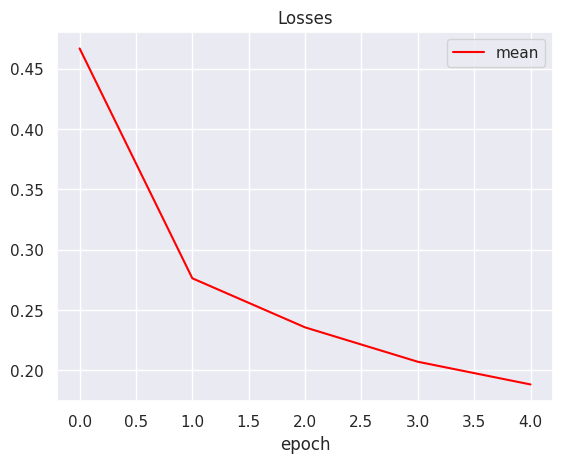

In [33]:
for (name, values), color in zip(losses_type_GRU_cat.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_cat[name])), losses_type_GRU_cat[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.86


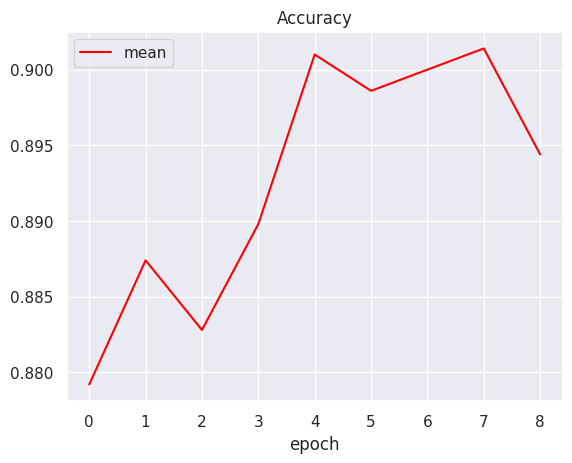

In [34]:
for (name, values), color in zip(losses_type_GRU_cat.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_cat[name][1:])), acc_type_GRU_cat[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# --------------------------- tune GRU ---------------------------

In [39]:
class CharLM_GRU_t(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        # return output

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [40]:
model_GRU_t = CharLM_GRU_t(hidden_dim=64, vocab_size=len(vocab), N_layers=1, dropout_rate=0.25).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_GRU_t.parameters())

In [41]:
print(model_GRU_t)

CharLM_GRU_t(
  (embedding): Embedding(11842, 64)
  (rnn): GRU(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=64, bias=True)
  (projection): Linear(in_features=64, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [42]:
out = 0
for i, batch in enumerate(tqdm(train_dataloader)):
    if i > 0:
        break
    out = model_GRU_t(batch['input_ids'])

  0%|          | 0/3750 [00:00<?, ?it/s]

In [43]:
print(out.shape)

torch.Size([32, 4])


In [39]:
%%time

num_epoch = 10
eval_steps = len(train_dataloader) // 2


losses_type_GRU_t = {}
acc_type_GRU_t = {}

best_acc = 0
path_to_best_model = '/content/drive/MyDrive/Deep_Learning_MIPT_2/part_5/best_model.pth'

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_t = CharLM_GRU_t(
        hidden_dim=64, vocab_size=len(vocab), N_layers=1, dropout_rate=0.25, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_t.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_t.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_t(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_t.eval()
                acc_now = evaluate(model_GRU_t, eval_dataloader)
                acc.append(acc_now)
                if acc_now > best_acc:
                    print(f"Best validation loss: {loss.item()}")
                    print(f"Best validation acc: {acc_now}")
                    print(f"Saving best model for epoch: {epoch}\n")
                    best_acc = acc_now
                    torch.save({
                    'epoch': epoch,
                    'model_state_dict': model_GRU_t.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    'acc':acc_now,
                    }, path_to_best_model)
                model_GRU_t.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_t[aggregation_type] = losses
    acc_type_GRU_t[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Best validation loss: 1.3767896890640259
Best validation acc: 0.24740000069141388
Saving best model for epoch: 0

Best validation loss: 0.19901524484157562
Best validation acc: 0.8709999918937683
Saving best model for epoch: 0



Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Best validation loss: 0.1598241776227951
Best validation acc: 0.8947999477386475
Saving best model for epoch: 1

Best validation loss: 0.5947335362434387
Best validation acc: 0.9005999565124512
Saving best model for epoch: 1



Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Best validation loss: 0.05789269506931305
Best validation acc: 0.9049999713897705
Saving best model for epoch: 3

Best validation loss: 0.10365625470876694
Best validation acc: 0.9057999849319458
Saving best model for epoch: 3



Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 9min 56s, sys: 9.06 s, total: 10min 5s
Wall time: 10min 17s


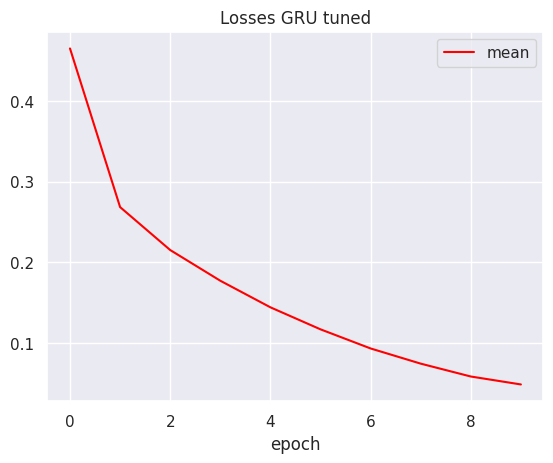

In [40]:
for (name, values), color in zip(losses_type_GRU_t.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_t[name])), losses_type_GRU_t[name], color=color, label=name)

plt.title('Losses GRU tuned')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.58


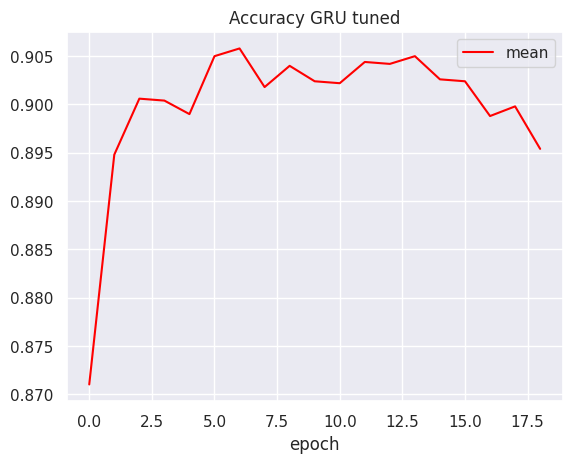

In [41]:
for (name, values), color in zip(losses_type_GRU_t.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_t[name][1:])), acc_type_GRU_t[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_t[name]) * 100):.2f}")

plt.title('Accuracy GRU tuned')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [29]:
class CharLM_GRU_t(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        return output, hidden

        # if self.aggregation_type == 'max':
        #     output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        # elif self.aggregation_type == 'mean':
        #     output = output.mean(dim=1) #[batch_size, hidden_dim]
        # else:
        #     raise ValueError("Invalid aggregation_type")

        # output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        # prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        # return prediction

In [30]:
model_GRU_t = CharLM_GRU_t(hidden_dim=64, vocab_size=len(vocab), embeding_len=100, N_layers=1, dropout_rate=0.25).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_GRU_t.parameters())

In [31]:
print(model_GRU_t)

CharLM_GRU_t(
  (embedding): Embedding(11842, 100)
  (rnn): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=64, bias=True)
  (projection): Linear(in_features=64, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [32]:
out, hid = 0, 0
for i, batch in enumerate(tqdm(train_dataloader)):
    if i > 0:
        break
    out, hid = model_GRU_t(batch['input_ids'])

  0%|          | 0/3750 [00:00<?, ?it/s]

In [34]:
print(f'out.shape = {out.shape}') # [batch_size, seq_len, hidden_dim]
print(f'hid.shape = {hid.shape}') # [1, batch_size, hidden_dim] скрытое состояние одно для всего предложения (память о нем после прочтения последнего слова)

out.shape = torch.Size([32, 58, 64])
hid.shape = torch.Size([1, 32, 64])


In [41]:
class CharLM_GRU_t_bd(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1, bd: bool = False
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, num_layers=N_layers, bidirectional=bd, batch_first=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim*2]

        return output, hidden
        # return output

        # if self.aggregation_type == 'max':
        #     output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        # elif self.aggregation_type == 'mean':
        #     output = output.mean(dim=1) #[batch_size, hidden_dim]
        # else:
        #     raise ValueError("Invalid aggregation_type")

        # # output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        # output = self.dropout(self.linear2(self.non_lin(output)))  # [batch_size, hidden_dim]
        # prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        # return prediction

In [42]:
model_GRU_t_bd = CharLM_GRU_t_bd(hidden_dim=64, vocab_size=len(vocab), embeding_len=100, N_layers=1, dropout_rate=0.25, bd=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_GRU_t_bd.parameters())

In [43]:
print(model_GRU_t_bd)

CharLM_GRU_t_bd(
  (embedding): Embedding(11842, 100)
  (rnn): GRU(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=64, bias=True)
  (projection): Linear(in_features=64, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [44]:
out_bd, hid_bd = 0, 0
for i, batch in enumerate(tqdm(train_dataloader)):
    if i > 0:
        break
    out_bd, hid_bd = model_GRU_t_bd(batch['input_ids'])

  0%|          | 0/3750 [00:00<?, ?it/s]

In [45]:
print(f'out_bd.shape = {out_bd.shape}')
print(f'hid_bd.shape = {hid_bd.shape}')

out_bd.shape = torch.Size([32, 71, 128])
hid_bd.shape = torch.Size([2, 32, 64])


In [46]:
print(f'out.shape = {out.shape}')
print(f'hid.shape = {hid.shape}')

out.shape = torch.Size([32, 58, 64])
hid.shape = torch.Size([1, 32, 64])


In [47]:
class CharLM_GRU_t_bd(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1, bd: bool = False
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, num_layers=N_layers, bidirectional=bd, batch_first=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim*2]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim*2]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim*2]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [61]:
%%time

num_epoch = 10
eval_steps = len(train_dataloader) // 2


losses_type_GRU_t_bd = {}
acc_type_GRU_t_bd = {}

best_acc = 0
path_to_best_model = '/content/drive/MyDrive/Deep_Learning_MIPT_2/part_5/best_model.pth'

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_t_bd = CharLM_GRU_t_bd(
        hidden_dim=64, vocab_size=len(vocab), embeding_len=64, N_layers=1, dropout_rate=0.25, bd=True, aggregation_type=aggregation_type).to(device)
    # model_GRU_t_bd = CharLM_GRU_t_bd(
    #     hidden_dim=64, vocab_size=len(vocab), embeding_len=32, N_layers=1, dropout_rate=0.25, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_t_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_t_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_t_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_t_bd.eval()
                acc_now = evaluate(model_GRU_t_bd, eval_dataloader)
                acc.append(acc_now)
                if acc_now > best_acc:
                    print(f"Best validation loss: {loss.item()}")
                    print(f"Best validation acc: {acc_now}")
                    print(f"Saving best model for epoch: {epoch}\n")
                    best_acc = acc_now
                    torch.save({
                    'epoch': epoch,
                    'model_state_dict': model_GRU_t.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    'acc':acc_now,
                    }, path_to_best_model)
                model_GRU_t_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_t_bd[aggregation_type] = losses
    acc_type_GRU_t_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Best validation loss: 1.4200938940048218
Best validation acc: 0.24300000071525574
Saving best model for epoch: 0

Best validation loss: 0.34293705224990845
Best validation acc: 0.8685999512672424
Saving best model for epoch: 0



Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Best validation loss: 0.29814279079437256
Best validation acc: 0.8883999586105347
Saving best model for epoch: 1

Best validation loss: 0.22257615625858307
Best validation acc: 0.8981999754905701
Saving best model for epoch: 1



Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Best validation loss: 0.3327086269855499
Best validation acc: 0.8987999558448792
Saving best model for epoch: 2



Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Best validation loss: 0.4831473231315613
Best validation acc: 0.9013999700546265
Saving best model for epoch: 3



Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Best validation loss: 0.16424164175987244
Best validation acc: 0.9079999923706055
Saving best model for epoch: 4



Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 10min 12s, sys: 9.04 s, total: 10min 21s
Wall time: 10min 32s


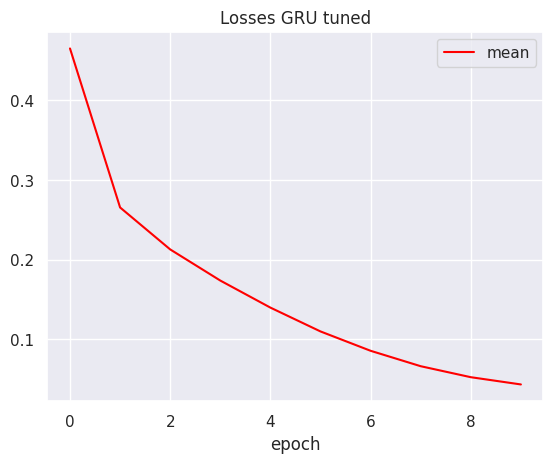

In [62]:
for (name, values), color in zip(losses_type_GRU_t_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_t_bd[name])), losses_type_GRU_t_bd[name], color=color, label=name)

plt.title('Losses GRU tuned')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.80


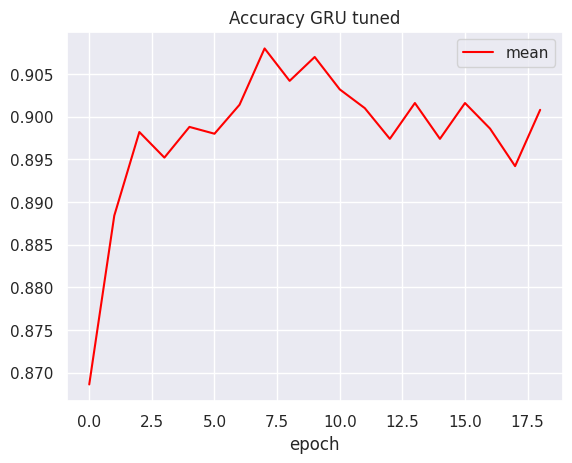

In [63]:
for (name, values), color in zip(losses_type_GRU_t_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_t_bd[name][1:])), acc_type_GRU_t_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_t_bd[name]) * 100):.2f}")

plt.title('Accuracy GRU tuned')
plt.xlabel("epoch")
plt.legend()
plt.show()